In [1]:
from dendrocat import RadioSource, MasterCatalog
from astropy.io import fits
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import sys
import importlib
from astropy.wcs import WCS
from regions import Regions, PixCoord
from astropy import stats
from itertools import chain
import dendrocat
from scipy import stats
import Paths.Paths as paths
Path = paths.filepaths()


/home/t.yoo/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def add_skycoordinates(cat, wcs):
    """
    Add sky coordinates to the catalog based on WCS information.
    
    Parameters:
    cat : dict
        The catalog containing peak_x and peak_y pixel coordinates.
    wcs : astropy.wcs.WCS
        The WCS object for converting pixel coordinates to sky coordinates.
    
    Returns:
    None: The function modifies the input catalog in place.
    """
    xypix = np.column_stack((cat['peak_x'].data, cat['peak_y'].data))
    xysky = wcs.wcs_pix2world(xypix, 0)
    cat['peak_x_sky'] = xysky[:, 0]
    cat['peak_y_sky'] = xysky[:, 1]

    
def check_overlap(image_dir1, image_dir2, cat1, cat2):
    cats = [cat1, cat2]
    print(cat1)
    catnum1 = len(cat1['peak_x_sky'])
    catnum2 = len(cat2['peak_y_sky'])
    isinside1 = np.zeros(catnum1, dtype=bool)
    isinside2 = np.zeros(catnum2, dtype=bool)
    isinsides = [isinside1, isinside2]
    image_dirs = [image_dir1, image_dir2]
    catnums = [catnum1, catnum2]
    for i, image_dir in enumerate(image_dirs):
        fitsdata = fits.open(image_dir)
        wcs = WCS(fitsdata[0].header,naxis=2)
        image = fitsdata[0].data[0][0]
        if len(image.shape)>2:
            image = fitsdata[0].data[0][0]

        cat_comp = cats[i] ; cat = cats[i-1]

        xpeak = cat['peak_x_sky']
        ypeak = cat['peak_y_sky']

        xypeak = np.vstack((xpeak,ypeak)).T

        xypix = wcs.wcs_world2pix(xypeak,0)
        
        for j in range(catnums[i-1]):
            if xypix[j,0] < 0 or xypix[j,1] < 0 or xypix[j,0]>=image.shape[0] or xypix[j,1] >= image.shape[1]:
                isinsides[i-1][j] = False
            
            else:
                isinsides[i-1][j] = np.isfinite(image[int(xypix[j,0]),int(xypix[j,1])])
                
    return isinsides

def auto_matching(cat1, cat2, threshold=0.01, verbose=False):
    
    catnum1 = len(cat1['peak_x_sky'])
    matchingind = []            
    for i in range(catnum1):
        dist = np.sqrt((cat1['peak_x_sky'][i] - cat2['peak_x_sky'])**2
                      +(cat1['peak_y_sky'][i] - cat2['peak_y_sky'])**2)
        if verbose:
            print(i,cat1['_name'][i],cat2['_name'][np.argmin(dist)],np.min(dist))
        if np.min(dist) < threshold:
            matchingind.append(np.argmin(dist))
        else:
            matchingind.append(-1)

        
    return np.array(matchingind)                       


    
    
        
    

In [3]:
from astropy.table import Table
w51n_B3_catalog = 'tables/W51-IRS2_B3_truncated_dendro.fits'
w51n_B6_catalog = 'tables/W51-IRS2_B6_truncated_dendro.fits'
b3cat = Table.read(w51n_B3_catalog)
b6cat = Table.read(w51n_B6_catalog)
isinsides = check_overlap(w51n_b3_tt0, w51n_b6_cont,b3cat, b6cat)
print(isinsides)
b6_to_b3_ind = auto_matching(b3cat, b6cat, threshold=1.5e-5)
b3_to_b6_ind = auto_matching(b6cat, b3cat, threshold=1.5e-5, verbose=True)
print(b6_to_b3_ind)
print(b3_to_b6_ind)
add_skycoordinates(b3cat, WCS(fits.open(Path.w51n_b3_tt0)[0].header, naxis=2))
add_skycoordinates(b6cat, WCS(fits.open(Path.w51n_b6_cont)[0].header, naxis=2))
isinsides = check_overlap



NameError: name 'w51n_b3_tt0' is not defined

### Making combined catalog

In [ ]:
from astropy.table import vstack
# making catalog with the sources with counterparts first

b3_ind_counterpart = np.where(b6_to_b3_ind>=0)
b3_counterpart = b3cat[b3_ind_counterpart]
b6_counterpart = b6cat[b6_to_b3_ind[b3_ind_counterpart]]

table_matched = Table([b3_counterpart['_name'], b6_counterpart['_name'], 
                    b3_counterpart['peak_x'], b3_counterpart['peak_y'],
                    b6_counterpart['peak_x'], b6_counterpart['peak_y'],
                    b3_counterpart['peak_x_sky'], b3_counterpart['peak_y_sky'],
                    b6_counterpart['peak_x_sky'], b6_counterpart['peak_y_sky'],
                    b3_counterpart['major_fwhm'], b3_counterpart['minor_fwhm'], b3_counterpart['position_angle'],
                    b6_counterpart['major_fwhm'], b6_counterpart['minor_fwhm'], b6_counterpart['position_angle'],
                    np.ones(len(b3_ind_counterpart[0]), dtype=bool), isinsides[0][b3_ind_counterpart]],
                   names=('b3_id','b6_id','b3_xpix','b3_ypix','b6_xpix','b6_ypix',
                          'b3_xsky','b3_ysky','b6_xsky','b6_ysky',
                          'b3_afwhm', 'b3_bfwhm', 'b3_pa',
                          'b6_afwhm', 'b6_bfwhm', 'b6_pa',
                          'is_matched','is_overlap')  
                  )
print(len(table_matched))                    
                    
b3_ind_nomatch = np.where(b6_to_b3_ind<0)
b3only = b3cat[b3_ind_nomatch]
b3only_num = len(b3_ind_nomatch[0])
dummyarr = np.ones(b3only_num)*(-1)
dummyarr_str = np.zeros(b3only_num, dtype=str)
table_b3only = Table([b3only['_name'], dummyarr_str,
                     b3only['peak_x'], b3only['peak_y'],
                     dummyarr, dummyarr,
                     b3only['peak_x_sky'], b3only['peak_y_sky'],
                     dummyarr, dummyarr,
                     b3only['major_fwhm'], b3only['minor_fwhm'], b3only['position_angle'],
                      dummyarr, dummyarr, dummyarr,
                     np.zeros(b3only_num, dtype=bool), isinsides[0][b3_ind_nomatch]],
                     names=('b3_id','b6_id','b3_xpix','b3_ypix','b6_xpix','b6_ypix',
                          'b3_xsky','b3_ysky','b6_xsky','b6_ysky',
                              'b3_afwhm', 'b3_bfwhm', 'b3_pa',
                          'b6_afwhm', 'b6_bfwhm', 'b6_pa',
                          'is_matched','is_overlap')  
                    )
print(len(table_b3only))                    

                     
b6_ind_nomatch = np.where(b3_to_b6_ind<0)
b6only = b6cat[b6_ind_nomatch]
b6only_num = len(b6_ind_nomatch[0])
dummyarr = np.ones(b6only_num)*(-1)
dummyarr_str = np.zeros(b6only_num, dtype=str)
table_b6only = Table([dummyarr_str, b6only['_name'], 
                     dummyarr, dummyarr,
                     b6only['peak_x'], b6only['peak_y'],
                     dummyarr, dummyarr,
                     b6only['peak_x_sky'], b6only['peak_y_sky'],
                     dummyarr, dummyarr, dummyarr,
                     b6only['major_fwhm'], b6only['minor_fwhm'], b6only['position_angle'],
                     np.zeros(b6only_num, dtype=bool), isinsides[1][b6_ind_nomatch]],
                     names=('b3_id','b6_id','b3_xpix','b3_ypix','b6_xpix','b6_ypix',
                          'b3_xsky','b3_ysky','b6_xsky','b6_ysky',
                          'b3_afwhm', 'b3_bfwhm', 'b3_pa',
                          'b6_afwhm', 'b6_bfwhm', 'b6_pa',
                          'is_matched','is_overlap')  
                    )
print(len(table_b6only))                    

table_fin = vstack([table_matched, table_b3only, table_b6only])
sortind = np.lexsort((table_fin['b6_id'],~table_fin['is_matched'],~table_fin['is_overlap']))
table_fin = table_fin[sortind]
table_fin.pprint_all()


# delete #73, #54 (starting index from 0)
# deleting some ambiguos sources by eye


table_fin.write('tables/dendro_w51n_matched.fits', format='fits', overwrite=True)


21
49
4
 b3_id   b6_id  b3_xpix b3_ypix b6_xpix b6_ypix      b3_xsky            b3_ysky            b6_xsky            b6_ysky              b3_afwhm               b3_bfwhm               b3_pa               b6_afwhm               b6_bfwhm               b6_pa        is_matched is_overlap
                                                                                                                                     deg                    deg                   deg                  deg                    deg                   deg                              
------- ------- ------- ------- ------- ------- ------------------ ------------------ ------------------ ------------------ ---------------------- ---------------------- ------------------- ---------------------- ---------------------- ------------------- ---------- ----------
9311874 2260047  8253.0  7015.0  9185.0  6717.0  290.9146520640484 14.517598602530239  290.9146540877684 14.517602211771774  3.310263163916576e-05 2.380881755

In [ ]:
from astropy.nddata.utils import Cutout2D, NoOverlapError
from astropy import coordinates, wcs
import astropy.units as u
from matplotlib import colors
from matplotlib.patches import Rectangle, Ellipse
from radio_beam import Beam

def get_cutout(image_dir, xpos, ypos, fwhm):
    fitsdata = fits.open(image_dir)
    wcs_image = WCS(fitsdata[0].header,naxis=2)
    image = fitsdata[0].data[0][0]
    if len(image.shape)>2:
        image = fitsdata[0].data[0][0]
    x_cen = xpos * u.deg
    y_cen = ypos * u.deg
    position = coordinates.SkyCoord(x_cen, y_cen,
                                    frame=wcs.utils.wcs_to_celestial_frame(wcs_image).name,
                                    unit=(u.deg, u.deg))
    pixel_scale = (np.abs(wcs_image.pixel_scale_matrix.diagonal().prod())**0.5 * u.deg)
    size = 10*fwhm
        #size = 24*pixel_scale + 2.5*fwhm * u.deg
    
    cutout = Cutout2D(image,
                          position,
                      size,
                      wcs=wcs_image,
                      mode='partial')
     

  
    return cutout

def add_scale_bar(ax, xpos,ypos,scale, pixel_scale, dist, unit='pc',height=20,color='w',pad=40,size=40):
    phy_pix_scale = pixel_scale.value * np.pi/180 * dist
    ax.add_patch(Rectangle((xpos,ypos),scale/phy_pix_scale,height,color=color))
    ax.text(xpos+0.4*scale/phy_pix_scale, ypos+pad, '%2.1f %s'%(scale, unit), color=color,fontsize=size)
                
def add_beam(ax,xpos,ypos,beam, pixel_scale,color='w'):
    width = beam.major / pixel_scale
    height = beam.minor /pixel_scale
    angle = beam.pa
    ax.add_patch(Ellipse((xpos,ypos),width.value,height.value,180-angle.value,color=color))

def plot_cutouts(ax, image_dir, xpos, ypos, fwhm, cmap='inferno', 
                 addbeam=True, scale=None, dist=None, 
                 vmin=-0.00010907209521789237, vmax=0.01065474459299, sqrtpower=True,
                label=None, mmlabel=None, nomatch=False):
    
    cutout = get_cutout(image_dir, xpos, ypos, fwhm)
    shape = cutout.data.shape
    hdr = fits.getheader(image_dir)  
    wcs = WCS(hdr,naxis=2)
    pixel_scale = wcs.proj_plane_pixel_scales()[0]
    beam = Beam.from_fits_header(hdr)

    if sqrtpower:
        ax.imshow(cutout.data, origin='lower', cmap=plt.get_cmap(cmap), 
              norm=colors.PowerNorm(gamma=0.5, vmin=vmin, vmax=vmax),aspect='equal')
    else:
        ax.imshow(cutout.data, origin='lower', cmap=plt.get_cmap(cmap), 
              vmin=vmin, vmax=vmax,aspect='auto')
    if addbeam:
        add_beam(ax, 0.15*shape[0], 0.15*shape[1], beam, pixel_scale)
    if scale is not None:
        add_scale_bar(ax, 0.8*shape[0], 0.2*shape[1], scale, pixel_scale, dist)
    if label is not None:
        ax.text(0.08*shape[0],0.85*shape[1], label, color='w', fontsize=35)
    if nomatch:
        mmlabelcolor='r'
    else:
        mmlabelcolor='w'
    if mmlabel is not None:
        ax.text(0.65*shape[0],0.85*shape[1], mmlabel, color=mmlabelcolor, fontsize=25)
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
source_num = len(table_fin)
hdr_b3 = fits.getheader(w51n_b3_tt0)
hdr_b6 = fits.getheader(w51n_b6_calibrated_pbcor)

beam_b3 = Beam.from_fits_header(hdr_b3)    
beam_b6 = Beam.from_fits_header(hdr_b6)    
print(source_num)

72


0 8253.0 7015.0
0 9185.0 6717.0
1 8101.0 7129.0
1 8918.0 6915.0
2 7028.0 7167.0
2 7041.0 6982.0
3 7628.0 7226.0
3 8095.0 7087.0
4 7826.0 7273.0
4 8439.0 7167.0
5 7491.0 7286.0
5 7851.0 7189.0
6 7604.0 7294.0
6 8050.0 7206.0
7 7648.0 7273.0
7 8129.0 7168.0
8 7764.0 7278.0
8 8330.0 7177.0
9 7343.0 7299.0
9 7592.0 7213.0
10 7146.0 7319.0
10 7248.0 7247.0
11 7185.0 7303.0
11 7311.0 7218.0
12 7552.0 7307.0
12 7960.0 7230.0
13 7115.0 7311.0
13 7192.0 7233.0
14 7782.0 7331.0
14 8362.0 7271.0
15 7083.0 7351.0
15 7138.0 7305.0
16 7047.0 7342.0
16 7075.0 7289.0
17 7047.0 7358.0
17 7076.0 7317.0
18 7008.0 7361.0
18 7005.0 7321.0
19 7272.0 7367.0
19 7469.0 7331.0
20 7256.0 7409.0
20 7438.0 7404.0
21 5417.0 5199.0
21 -1.0 -1.0
22 6974.0 6859.0
22 -1.0 -1.0
23 7650.0 7251.0
23 -1.0 -1.0
24 7183.0 7333.0
24 -1.0 -1.0
25 9821.0 7570.0
25 -1.0 -1.0
26 6011.0 7605.0
26 -1.0 -1.0
27 5318.0 7617.0
27 -1.0 -1.0
28 -1.0 -1.0
28 6099.0 7004.0
29 -1.0 -1.0
29 8111.0 7179.0
30 -1.0 -1.0
30 7483.0 7305.0
31 -1.

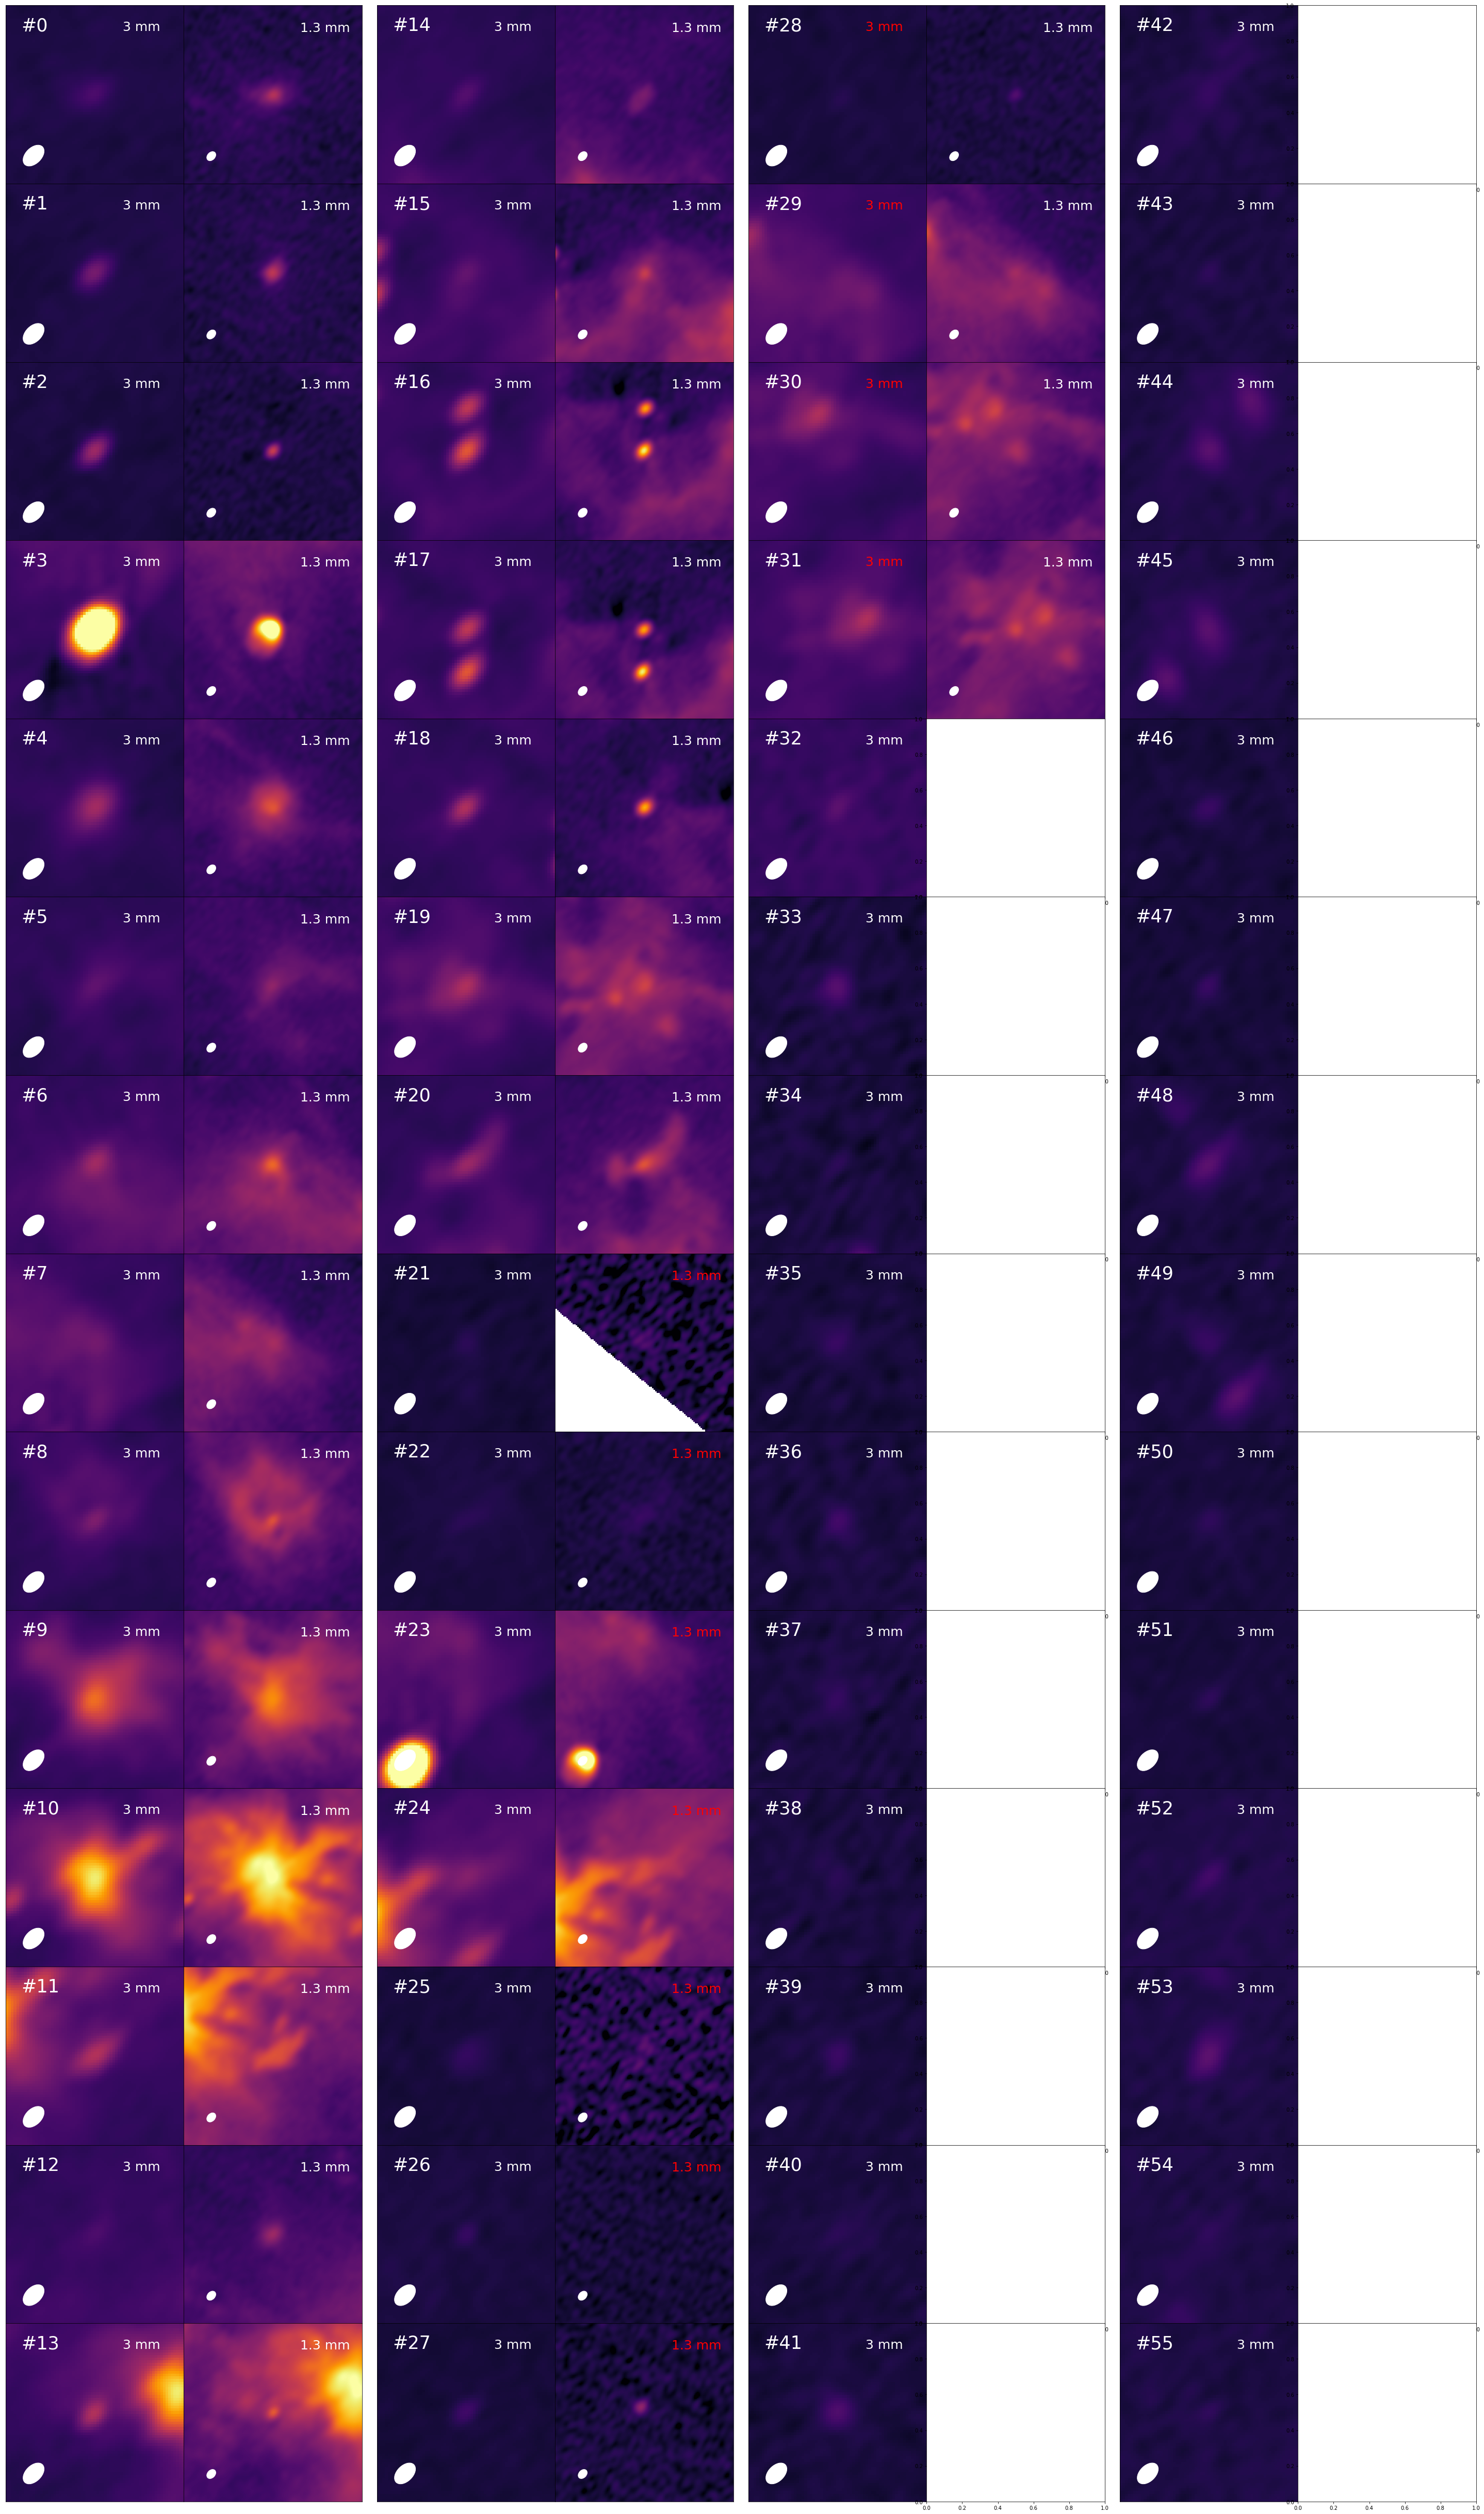

In [ ]:

table_fin_w51n = Table.read('tables/dendro_w51e_matched.fits')

w51n_ra = []
w51n_dec = []
for i in range(len(table_fin_w51n)): 
    if table_fin_w51n['b6_xsky'][i] < 0:
        w51n_ra.append(table_fin_w51n['b3_xsky'][i])
        w51n_dec.append(table_fin_w51n['b3_ysky'][i])
    else:
        w51n_ra.append(table_fin_w51n['b6_xsky'][i])
        w51n_dec.append(table_fin_w51n['b6_ysky'][i])  

w51e_ra = []
w51e_dec = []
for i in range(len(table_fin)): 
    if table_fin['b6_xsky'][i] < 0:
        w51e_ra.append(table_fin['b3_xsky'][i])
        w51e_dec.append(table_fin['b3_ysky'][i])
    else:
        w51e_ra.append(table_fin['b6_xsky'][i])
        w51e_dec.append(table_fin['b6_ysky'][i])

duplicated = []
for i in range(len(table_fin)):
    dist = np.sqrt((w51n_ra - w51e_ra[i])**2 + (w51n_dec - w51e_dec[i])**2)
    if np.min(dist)<0.03/3600:
        print(i,np.min(dist),np.argmin(dist))
        duplicated.append(i)
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111)
w51e_b3_fitsdata = fits.open(Path.w51e_b3_tt0)
w51e_b3_image = w51e_b3_fitsdata[0].data
ax.imshow(w51e_b3_image[0][0], origin='lower', cmap=plt.get_cmap('inferno'),vmin=-0.000311680, vmax=0.001241484998551493)
wcs_w51e_b3 = WCS(w51e_b3_fitsdata[0].header,naxis=2)
pixxy = wcs_w51e_b3.wcs_world2pix(np.array(w51e_ra), np.array(w51e_dec), 0)
print(pixxy[0])
print(duplicated)
ax.scatter(np.array(pixxy[0])[duplicated], np.array(pixxy[1])[duplicated], marker='o', facecolor='none',edgecolor='cyan', s=100, label='W51n')
plt.savefig('pngs/matched_catalog_w51n.png')

56 2657.0 5719.0
57 3439.0 5704.0
58 3458.0 5806.0
59 2497.0 5843.0
60 3380.0 6064.0
61 1277.0 6307.0
62 13741.0 6922.0
63 1919.0 7147.0
64 11283.0 7350.0
65 10987.0 7517.0
66 3141.0 8034.0
67 10541.0 8086.0
68 1858.0 8146.0
69 8018.0 10882.0
70 8082.0 10889.0
71 7998.0 10924.0


IndexError: index 72 is out of bounds for axis 0 with size 72

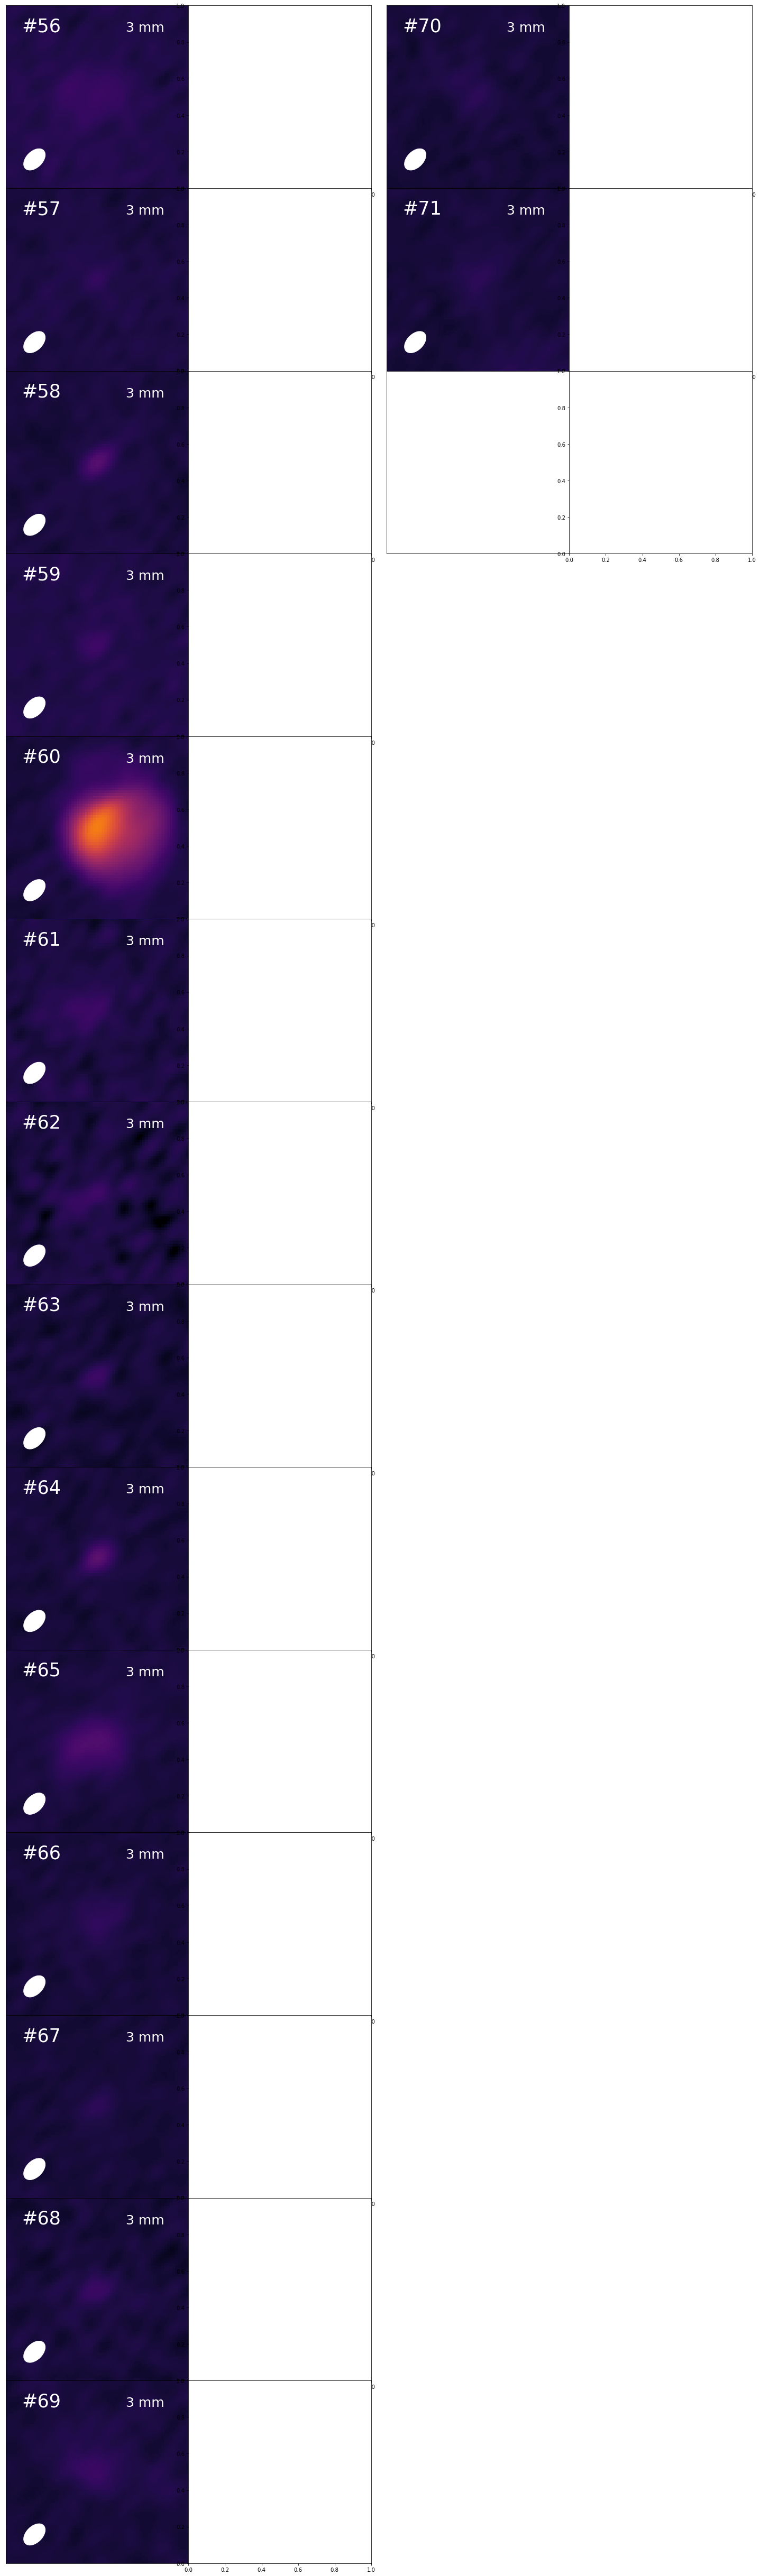

In [ ]:
from matplotlib.gridspec import GridSpec


fig = plt.figure(figsize=(figsize,figsize*ratio))
gs1 = GridSpec(nrow, 2, left=margin, right=margin+width, wspace=0.00, hspace=0.00, top=top, bottom=bottom)
gs2 = GridSpec(nrow, 2, left=2*margin+width, right=2*(margin+width), wspace=0.00, hspace=0.00,top=top,bottom=bottom)
gs3 = GridSpec(nrow, 2, left=3*margin+2*width, right=3*(margin+width), wspace=0.00, hspace=0.00,top=top,bottom=bottom)
gs4 = GridSpec(nrow, 2, left=4*margin+3*width, right=4*(margin+width), wspace=0.00, hspace=0.00,top=top,bottom=bottom)


gss = [gs1, gs2, gs3, gs4]
num = nrow*ncol    
for i in range(num):
    gsind = int(i/nrow)
    rowind = i - gsind*nrow
    ax1 = fig.add_subplot(gss[gsind][rowind,0])
    ax2 = fig.add_subplot(gss[gsind][rowind,1])
    ax1.set_aspect('auto')
    ax2.set_aspect('auto')
    ax1.set_xticks([])
    ax1.set_yticks([])

    xpos_b3 = table_fin['b3_xsky'][i+num]
    ypos_b3 = table_fin['b3_ysky'][i+num]
    fwhm_b3 = table_fin['b3_afwhm'][i+num]
    
    xpos_b6 = table_fin['b6_xsky'][i+num]
    ypos_b6 = table_fin['b6_ysky'][i+num]
    fwhm_b6 = table_fin['b6_afwhm'][i+num]
    
    isoverlap = table_fin['is_overlap'][i+num]
   # print(isoverlap)
    b3continue=True ; b6continue=True
    nomatch_b3 = False ; nomatch_b6 = False

    if not isoverlap:
        if xpos_b3 < 0 or ypos_b3 <0:
            b3continue=False
        if xpos_b6 < 0 or ypos_b6 <0:
            b6continue=False
    else:
        if xpos_b3 < 0 or ypos_b3 <0:
            xpos_b3 = xpos_b6 ; ypos_b3 = ypos_b6 ; fwhm_b3 = fwhm_b6
            nomatch_b3=True

        if xpos_b6 < 0 or ypos_b6 <0:
            xpos_b6 = xpos_b3 ; ypos_b6 = ypos_b3 ; fwhm_b6 = fwhm_b3
            nomatch_b6=True

    size = (beam_b3.major+beam_b6.major)/2        
    
    if b3continue:
        #print(table_fin['b3_xpix'][i+num], table_fin['b3_ypix'][i+num], table_fin['b3_afwhm'][i+num])
        plot_cutouts(ax1, w51n_b3_tt0, xpos_b3, ypos_b3, size,label='#%d'%(i+num), mmlabel='3 mm',nomatch=nomatch_b3)
        print(i+num, table_fin['b3_xpix'][i+num], table_fin['b3_ypix'][i+num])

    if b6continue:
        #print(xpos_b6, ypos_b6, fwhm_b6)
        #print(table_fin['b6_xpix'][i+num], table_fin['b6_ypix'][i+num],table_fin['b6_afwhm'][i+num])
        
        plot_cutouts(ax2, w51n_b6_calibrated_pbcor, xpos_b6, ypos_b6, size, mmlabel='1.3 mm',nomatch=nomatch_b6)
        print(i+num, table_fin['b6_xpix'][i+num], table_fin['b6_ypix'][i+num])


plt.savefig('matched_catalog2_w51n.png')

             
            

In [ ]:

fig = plt.figure(figsize=(24,9))
gs1 = GridSpec(3,8, left=0.00, right=1.00, wspace=0.00, hspace=0.00, top=1.00, bottom=0.00)
ncol=8; nrow=3
num = nrow*ncol    
for i in range(24):
   
    rowind = int(i/ncol)
    colind = i - ncol*rowind
    print(rowind,colind)
    ax1 = fig.add_subplot(gs1[rowind,colind])
    #ax2 = fig.add_subplot(gs1[rowind,1])
    ax1.set_aspect('auto')
    #ax2.set_aspect('auto')
    ax1.set_xticks([])
    ax1.set_yticks([])
    if i+112 > len(table_fin)-1:
        continue

    xpos_b3 = table_fin['b3_xsky'][i+112]
    ypos_b3 = table_fin['b3_ysky'][i+112]
    fwhm_b3 = table_fin['b3_afwhm'][i+112]
    
    #xpos_b6 = table_fin['b6_xsky'][i+num*2]
    #ypos_b6 = table_fin['b6_ysky'][i+num*2]
    #fwhm_b6 = table_fin['b6_afwhm'][i+num*2]
    
    isoverlap = table_fin['is_overlap'][i+112]
   # print(isoverlap)
    b3continue=True ; b6continue=True
    if not isoverlap:
        if xpos_b3 < 0 or ypos_b3 <0:
            b3continue=False
    #    if xpos_b6 < 0 or ypos_b6 <0:
    #        b6continue=False
    else:
        if xpos_b3 < 0 or ypos_b3 <0:
            xpos_b3 = xpos_b6 ; ypos_b3 = ypos_b6 ; fwhm_b3 = fwhm_b6
            nomatch_b3=True

     #   if xpos_b6 < 0 or ypos_b6 <0:
      #      xpos_b6 = xpos_b3 ; ypos_b6 = ypos_b3 ; fwhm_b6 = fwhm_b3
       #     nomatch_b6=True

    size = (beam_b3.major+beam_b6.major)/2     
    if b3continue:
        #print(table_fin['b3_xpix'][i+num], table_fin['b3_ypix'][i+num], table_fin['b3_afwhm'][i+num])
        plot_cutouts(ax1, w51e_b3_tt0, xpos_b3, ypos_b3, size,label='#%d'%(i+112), mmlabel='3 mm',nomatch=nomatch_b3)
   # if b6continue:
   #     #print(xpos_b6, ypos_b6, fwhm_b6)
        #print(table_fin['b6_xpix'][i+num], table_fin['b6_ypix'][i+num],table_fin['b6_afwhm'][i+num])
        
    #    plot_cutouts(ax2, w51e_b6_calibrated_pbcor, xpos_b6, ypos_b6, size, mmlabel='1.3 mm',nomatch=nomatch_b6)
plt.savefig('matched_catalog3_w51n.png')
